# Amazon Bedrock Claude3
- Claude3이 되면서 기존 Claude2/2.1에서 사용하는 prompt 메시지 방식이 새롭게 개선되었습니다.
- 새로운 메시지 API는 아래와 같은 주요 이점을 제공합니다:
  - 이미지 처리: 메시지 API는 Claude로 이미지를 처리할 수 있는 유일한 방법으로, 이미지 분류, 물체 감지 등과 같은 작업에 고급 컴퓨터 비전 기능을 활용할 수 있습니다.
  - Claude 3 모델로 구축하기: 가장 강력한 최신 Claude 3 모델은 메시지 API를 통해서만 호출할 수 있습니다. 업그레이드를 통해 향상된 성능과 기능을 활용할 수 있습니다.
  - 향상된 오류 처리: 메시지 API를 사용하면 더욱 유익하고 유용한 오류 메시지를 반환할 수 있으므로 요청의 문제를 더 쉽게 진단하고 해결할 수 있습니다.
  - 요청 유효성 검사 개선: 메시지 API를 사용하면 사용자의 API 요청을 보다 효과적으로 검증할 수 있으므로, 사용자가 모델에서 최고 품질의 결과와 최상의 성능을 얻을 수 있습니다.
- 참고 자료 
  - https://docs.anthropic.com/claude/docs/upgrading-from-the-text-completions-api
  - https://docs.anthropic.com/claude/reference/messages_post

In [1]:
!pip install -U boto3 botocore

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 130.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: botocore
    Found existing installation: botocore 1.34.122
    Uninstalling botocore-1.34.122:
      Successfully uninstalled botocore-1.34.122
  Attempting uninstall: boto3
    Found existing installation: boto3 1.34.122
    Uninstalling boto3-1.34.122:
      Successfully uninstalled boto3-1.34.122
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.33.4 requires botocore==1.34.122, but you have botocore 1.34.136 which is incompatible.


## 1. Bedrock 호출 함수 선언

In [1]:
def image_to_base64(img):
    import os
    import base64
    """Converts a PIL Image or local image file path to a base64 string"""
    if isinstance(img, str):
        if os.path.isfile(img):
            print(f"Reading image from file: {img}")
            with open(img, "rb") as f:
                return base64.b64encode(f.read()).decode("utf-8")
        else:
            raise FileNotFoundError(f"File {img} does not exist")
    elif isinstance(img, Image.Image):
        buffer = io.BytesIO()
        img.save(buffer, format="PNG")
        return base64.b64encode(buffer.getvalue()).decode("utf-8")
    else:
        raise ValueError(f"Expected str (filename) or PIL Image. Got {type(img)}")

        
def open_image(img_path):
    with open(img_path, "rb") as f:
        image = f.read()
    return image

        
def bedrock_claude3(messages, model='haiku', stream=True, system=None, region_name='us-west-2'):
    import boto3
    import json
    from botocore.config import Config
    
    config = Config(
        read_timeout=600, ## Timeout 시간 조정
        retries = dict(
            max_attempts = 8 ## Retry 횟수 조정
        )
    )

    # Create a Bedrock Runtime client in the AWS Region of your choice.
    client = boto3.client("bedrock-runtime", region_name=region_name, config=config)


    if model == 'opus':
        model_id = "anthropic.claude-3-opus-20240229-v1:0"
    elif model == 'sonnet':
        model_id = "anthropic.claude-3-sonnet-20240229-v1:0"
    else:
        model_id = "anthropic.claude-3-haiku-20240307-v1:0"

    params = {
        "anthropic_version": "bedrock-2023-05-31",
        "max_tokens": 512,
        "temperature": 0.5,
        "top_k": 350,
        "top_p": 0.999,
        "messages": messages
    }
    
    if system:
        params['system'] = system

    # Convert the native request to JSON.
    request = json.dumps(params)

    if stream:
        # Invoke the model with the request.
        streaming_response = client.invoke_model_with_response_stream(
            modelId=model_id, body=request
        )
        response_text = ""
        # Extract and print the response text in real-time.
        for event in streaming_response["body"]:
            chunk = json.loads(event["chunk"]["bytes"])
            if chunk["type"] == "content_block_delta":
                text = chunk["delta"].get("text", "")
                print(text, end="")
                response_text += str(text)
    else:
        response = client.invoke_model(modelId=model_id, body=request)
        model_response = json.loads(response["body"].read())
        response_text = model_response["content"][0]["text"]
        print(response_text)

    return response_text


def claude_converse(messages, model='haiku', stream=True, system=None, toolConfig=None, region_name='us-west-2'):
    import boto3
    from botocore.config import Config
    
    config = Config(
        read_timeout=600, ## Timeout 시간 조정
        retries = dict(
            max_attempts = 8 ## Retry 횟수 조정
        )
    )

    # Create a Bedrock Runtime client in the AWS Region of your choice.
    client = boto3.client("bedrock-runtime", region_name=region_name, config=config)

    
    params = {}
    
    params['messages'] = messages
    
    if model == 'opus':
        params['modelId'] = "anthropic.claude-3-opus-20240229-v1:0"
    elif model == 'sonnet':
        params['modelId'] = "anthropic.claude-3-sonnet-20240229-v1:0"
    else:
        params['modelId'] = "anthropic.claude-3-haiku-20240307-v1:0"
    
    
    # Format the request payload using the model's native structure.
    params['inferenceConfig'] = {
        "maxTokens": 512,
        "temperature": 0.5,
        "topP": 0.999
    }

    ## Additional inference parameters that the model supports
    params['additionalModelRequestFields'] = {"top_k": 350}
    
    if system:
        params['system'] = [{"text" : system}]
    
    # print(f"tools : {tools}")
    if toolConfig:
        params['toolConfig'] = toolConfig
    
    if stream:
        response = client.converse_stream(**params)
    else:
        response = client.converse(**params)
    return response


def output_claude_converse_stream(messages, model='haiku',system=None, toolConfig=None, region_name='us-west-2'):
    from botocore.exceptions import ClientError
    import json
    try:
        response = claude_converse(messages, model, True, system, toolConfig, region_name)
        msg_tooluse = ""
        msg_print = False
        stream_response = response.get('stream')
        for event in stream_response:
            if 'messageStart' in event:
                print(f"\nRole: {event['messageStart']['role']}")

            if 'contentBlockDelta' in event:
                delta = event['contentBlockDelta']['delta']
                if delta.get('text'):
                    print(event['contentBlockDelta']['delta']['text'], end="")
                elif delta.get('toolUse'):
                    msg_tmp = event['contentBlockDelta']['delta']['toolUse']['input']
                    
                    if msg_tmp != "":
                        msg_tooluse += msg_tmp
                    else:
                        if msg_tooluse != "":
                            try:
                                msg_tooluse = json.loads(msg_tooluse)
                                for item in msg_tooluse:
                                    msg_tooluse[item] = msg_tooluse[item].encode().decode("utf-8")
                                    print(msg_tooluse)
                                    msg_tooluse = ""
                                    msg_print = True
                            except:
                                pass
        if msg_tooluse != "" and not msg_print:
            print(msg_tooluse)
            if 'messageStop' in event:
                print(f"\nStop reason: {event['messageStop']['stopReason']}")

            if 'metadata' in event:
                metadata = event['metadata']
                if 'usage' in metadata:
                    print("\nToken usage")
                    print(f"Input tokens: {metadata['usage']['inputTokens']}")
                    print(
                        f"Output tokens: {metadata['usage']['outputTokens']}")
                    print(f"Total tokens: {metadata['usage']['totalTokens']}")
                if 'metrics' in event['metadata']:
                    print(
                        f"Latency: {metadata['metrics']['latencyMs']} milliseconds")
    except ClientError as err:
        message = err.response['Error']['Message']
        print("A client error occurred: %s", message)

    else:
        print(
            f"\nFinished generating text with model {model}.")
    return response


def output_claude_converse(messages, model='haiku', system=None, toolConfig=None, region_name='us-west-2'):
    from botocore.exceptions import ClientError
    try:
        response = claude_converse(messages, model, False, system, toolConfig, region_name)

        output_message = response['output']['message']

        print(f"Role: {output_message['role']}")

        for content in output_message['content']:
            if content.get("text"):
                print(f"Text: {content['text']}")
            elif content.get("toolUse"):
                print(f"toolUseId: {content['toolUse']['toolUseId']}")
                print(f"name: {content['toolUse']['name']}")
                print(f"input: {content['toolUse']['input']}")
        token_usage = response['usage']
        print(f"Input tokens:  {token_usage['inputTokens']}")
        print(f"Output tokens:  {token_usage['outputTokens']}")
        print(f"Total tokens:  {token_usage['totalTokens']}")
        print(f"Stop reason: {response['stopReason']}")  
    
    except ClientError as err:
        message = err.response['Error']['Message']
        print("A client error occurred: %s", message)
    else:
        print(
            f"\nFinished generating text with model {model}.")
    return response


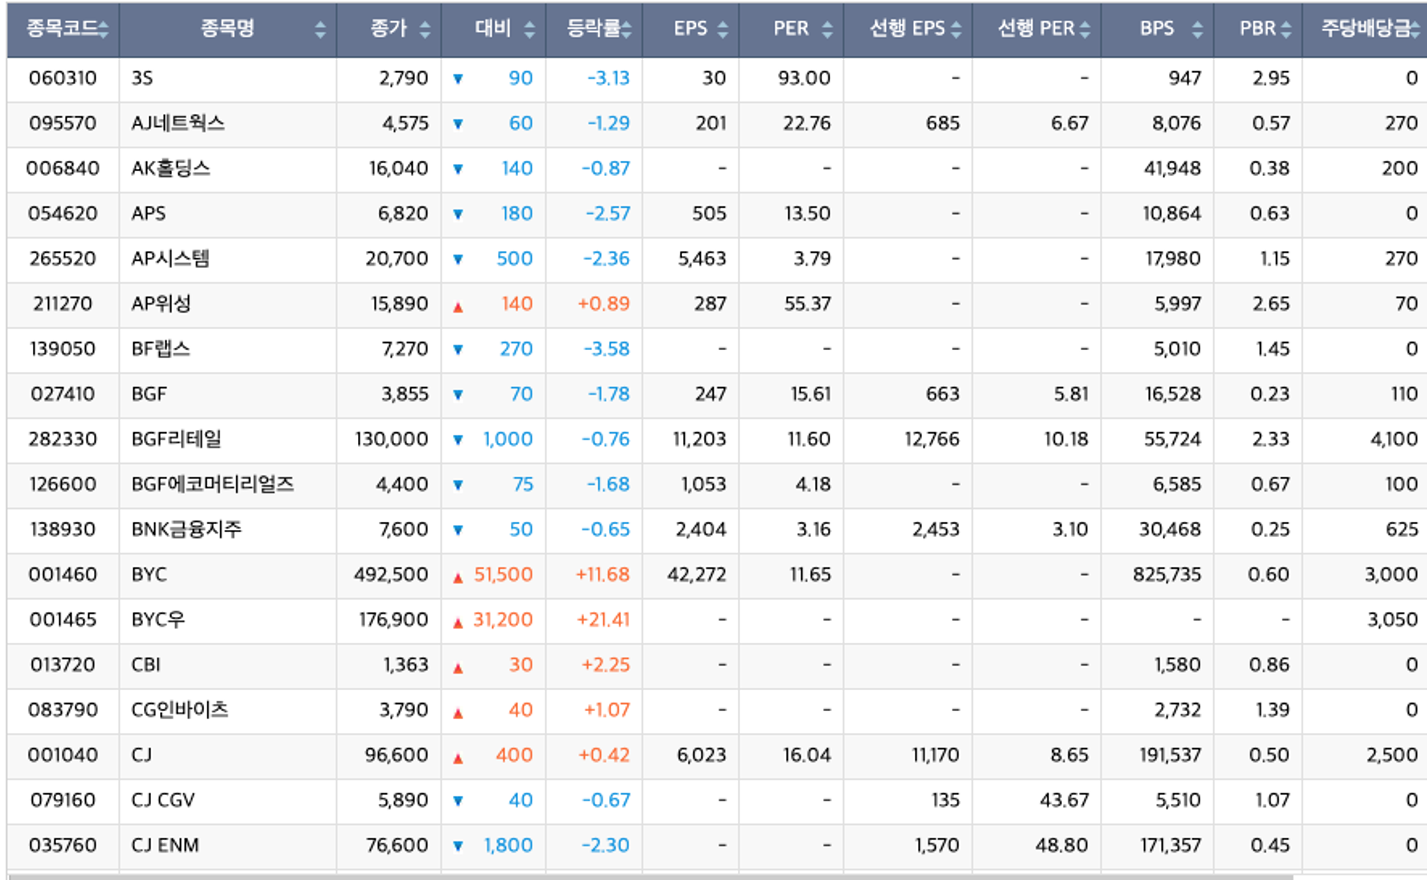

In [2]:
from PIL import Image
image_path = 'profit_table.png'
Image.open(image_path)

## 2. Converse API를 이용한 Text 및 table 이미지 테스트
- https://docs.aws.amazon.com/bedrock/latest/userguide/conversation-inference.html#message-inference-examples

In [3]:
%%time
prompt = "나는 인공지능 AI 보험 서비스입니다. 생명과 손해 보험의 차이에 대해 설명해 주세요."
message = [{"role": "user", "content": [{"text": prompt}]}]

# response = output_claude_converse_stream(message, model='sonnet')  ## stream
response = output_claude_converse(message, model='sonnet') 

Role: assistant
Text: 생명보험과 손해보험은 보험의 주요 유형으로 다음과 같이 구분됩니다.

1. 생명보험
- 사람의 생명과 관련된 위험을 보장합니다.
- 주요 종류로는 사망보험, 생존보험, 상해보험 등이 있습니다.
- 피보험자가 사망하거나 일정 기간 생존 시 보험금을 지급합니다.
- 장기적인 위험을 대비하기 위한 목적입니다.

2. 손해보험  
- 재산상의 손해나 배상책임 등의 경제적 손실 위험을 보장합니다.
- 주요 종류로는 화재보험, 배상책임보험, 상해보험, 자동차보험 등이 있습니다.
- 피보험 이익에 발생한 손해를 실제 가액 내에서 보상합니다.
- 단기적인 위험에 대비하기 위한 목적입니다.

생명보험은 개인의 생명과 관련된 장기 위험을, 손해보험은 재산 피해나 배상책임 등의 단기 경제적 손실 위험을 보장하는 것이 주된 차이점입니다. 보험 가입 목적과 보장 대상, 보험기간 등에서 구분됩니다.
Input tokens:  55
Output tokens:  440
Total tokens:  495
Stop reason: end_turn

Finished generating text with model sonnet.
CPU times: user 164 ms, sys: 20.9 ms, total: 185 ms
Wall time: 7.77 s


In [4]:
%%time
prompt = "AP위성의 종가가 어떻게 되나요?"
message = [{
    "role": "user",
    "content": [
        { "text": "Image 1:" },
        {"image": {"format": 'png', "source": {"bytes": open_image(image_path)}}},  # 'png'|'jpeg'|'gif'|'webp'
        {"text": prompt}
    ]
}]

response = output_claude_converse_stream(message, model='sonnet')  ## stream
# response = output_claude_converse(message, model='sonnet') 


Role: assistant
AP위성의 종가는 15,890원입니다. 해당 표에서 AP위성의 종목코드 211270에 해당하는 행을 보면, 종가 열에 15,890이라고 기재되어 있습니다.
Finished generating text with model sonnet.
CPU times: user 26.9 ms, sys: 3.13 ms, total: 30 ms
Wall time: 2.61 s


In [5]:
content = """
제삼이가 곡물로 국내산 찰보리쌀 1kg을 구매하고, 영준이는 농협에서 수입산 보리쌀 2Kg과 국내산 찰보리쌀 5KG을 주문했다.
"""

message = [{
    "role": "user",
    "content": [
        { "text": f"<content>{content}</content>" },
        { "text": "Please use the cateorize_items tool to generate the item category JSON based on the content within the <content> tags." }
    ],
}]

toolConfig={
    "tools": [
    {
        "toolSpec": {
            "name": "cateorize_items",
            "description": "입력 내용을 카테고리화",
            "inputSchema": {
                "json": {
                    "type": "object",
                    "properties": {
                        "item_name": {
                            "type": "string",
                            "description": "예를 들어 보리쌀, 청피망 등과 같은 단일 품목의 이름 입니다."
                        },
                        "origin": {
                            "type": "string",
                            "description": "예를 들어 국내산, 수입산 또는 롯데 등과 같은 원산지 또는 제조업체 정보 입니다."
                        },
                        "unit": {
                            "type": "string",
                            "description": "예를 들어 1kg, 1k(180~230g) 등과 같은 규격에 대한 정보 입니다."
                        },
                        "description": {
                            "type": "string",
                            "description": "프롬프트에 있는 모든 정보"
                        }
                    },
                    "required": [
                        "item_name",
                        "origin",
                        "unit",
                        "description"
                    ]
                }
            }
        }
    }
]
,
    "toolChoice": {
        "tool": {
            "name": "cateorize_items"
        }
    }
}

response = output_claude_converse(message, model='sonnet', toolConfig=toolConfig) 
# response = output_claude_converse_stream(message, model='sonnet', toolConfig=toolConfig)  ## 한국어 encoding 문제

Role: assistant
toolUseId: tooluse_3s1QZ5yYSnaGDre5KJV3_w
name: cateorize_items
input: {'item_name': '찰보리쌀', 'origin': '국내산', 'unit': '1kg', 'description': '제삼이가 곡물로 국내산 찰보리쌀 1kg을 구매하고'}
toolUseId: tooluse_R8Tjt5y7Sr2MQoIp6aMuwQ
name: cateorize_items
input: {'item_name': '보리쌀', 'origin': '수입산', 'unit': '2Kg', 'description': '영준이는 농협에서 수입산 보리쌀 2Kg과 국내산 찰보리쌀 5KG을 주문했다.'}
toolUseId: tooluse_vjUrSlp3T1epLsAKEr34bA
name: cateorize_items
input: {'item_name': '찰보리쌀', 'origin': '국내산', 'unit': '5KG', 'description': '영준이는 농협에서 수입산 보리쌀 2Kg과 국내산 찰보리쌀 5KG을 주문했다.'}
Input tokens:  974
Output tokens:  417
Total tokens:  1391
Stop reason: tool_use

Finished generating text with model sonnet.


## 3. Invoke model를 이용한 Text 및 table 이미지 테스트


In [6]:
%%time
prompt = "나는 인공지능 AI 보험 서비스입니다. 생명과 손해 보험의 차이에 대해 설명해 주세요."
message = [{"role": "user", 
            "content": [
                {"type": "text", "text": prompt},
            ]
           }]

response = bedrock_claude3(message, model='sonnet', stream=True, system=None, region_name='us-west-2')

생명보험과 손해보험은 보험의 주요 유형으로 다음과 같은 차이점이 있습니다.

1. 보장 대상
- 생명보험: 사람의 생명과 관련된 위험을 보장합니다. 예를 들어 사망, 상해, 질병 등
- 손해보험: 재산상의 손해나 법적 배상책임을 보장합니다. 예를 들어 화재, 교통사고, 배상책임 등

2. 보험기간
- 생명보험: 주로 장기계약이며 가입 시 예정된 기간 동안 보장됩니다.  
- 손해보험: 단기계약이 일반적이며 1년 만기로 갱신하는 방식입니다.

3. 보험금 지급
- 생명보험: 가입 시 약정한 사유가 발생하면 보험금이 지급됩니다.
- 손해보험: 실제 입은 손해액수만큼만 보상하는 실손보상 원칙입니다.

4. 보험료 산정 기준
- 생명보험: 사망률, 이자율 등 확률론적 계산에 기초합니다.
- 손해보험: 과거 손해율 통계를 기초로 합니다.

이처럼 생명보험과 손해보험은 보장대상, 기간, 보험금 지급방식, 보험료 산정 기준 등에서 차이가 있습니다.CPU times: user 59.6 ms, sys: 12 ms, total: 71.5 ms
Wall time: 7.64 s


In [7]:
%%time
prompt = "AP위성의 종가가 어떻게 되나요?"
message = [{"role": "user",
            "content": [
                {"type": "image", "source": { "type": "base64", "media_type": "image/png", "data": image_to_base64(image_path)}},  ## image/jpeg, image/webp, image/gif
                {"type": "text", "text": prompt},
            ],
           }
          ]

response = bedrock_claude3(message, 'sonnet', True)

Reading image from file: profit_table.png
AP위성의 종가는 15,890원입니다. 해당 표에서 AP위성의 종목코드는 211270이며, 종가 열에 15,890이라고 기재되어 있습니다.CPU times: user 29.4 ms, sys: 0 ns, total: 29.4 ms
Wall time: 2.47 s


## 4. Multi-turn을 고려한 Message 전달 방식 테스트

In [8]:
%%time
prompt1 = "나는 인공지능 AI 보험 서비스입니다. 생명과 손해 보험의 차이에 대해 설명해 주세요."
message = [
    {"role": "user", "content": [{"type": "text", "text": prompt1}]},
]

response1 = bedrock_claude3(message, 'sonnet', True)

생명보험과 손해보험은 다음과 같은 주요 차이점이 있습니다.

1. 보장 대상
- 생명보험: 사람의 생명과 관련된 위험을 보장합니다. 예를 들어 사망, 상해, 질병 등
- 손해보험: 재산상의 손해나 법적 배상책임을 보장합니다. 예를 들어 화재, 교통사고, 배상책임 등

2. 보험기간
- 생명보험: 장기계약이 일반적이며 종신, 20년만기 등이 있습니다.
- 손해보험: 단기계약이 일반적이며 1년 만기로 갱신하는 방식입니다.

3. 보험금 지급
- 생명보험: 가입 때 정한 사유가 발생하면 정액의 보험금을 지급합니다.
- 손해보험: 실제 발생한 손해액수를 보상하는 실손보상 방식입니다.

4. 보험료 산정기준
- 생명보험: 사망률, 이자율 등 통계적 요소로 보험료를 산출합니다. 
- 손해보험: 손해율, 사고발생 빈도 등을 고려하여 보험료를 결정합니다.

따라서 생명보험은 개인의 생명위험을 장기간 보장하는 반면, 손해보험은 재산 및 배상책임 등의 단기 위험을 보상하는 차이가 있습니다.CPU times: user 73.1 ms, sys: 1.73 ms, total: 74.8 ms
Wall time: 7.34 s


In [9]:
%%time
prompt2 = "대상을 좀더 상세히 설명해 주세요"
message = [
    {"role": "user", "content": [{"type": "text", "text": prompt1}]},
    {"role": "assistant", "content": response1},
    {"role": "user", "content": [{"type": "text", "text": prompt2}]},
]

response2 = bedrock_claude3(message, 'sonnet', True)

생명보험과 손해보험의 보장 대상을 좀 더 자세히 설명드리겠습니다.

생명보험:
- 사망보장: 가입자가 사망할 경우 유족에게 사망보험금을 지급
- 상해/질병보장: 상해나 특정 질병에 대한 진단비, 수술비, 입원비 등 실손의료비 보장
- 간병보장: 중증질환이나 상해로 인한 간병인 비용 보장
- 노후소득보장: 연금보험 등을 통해 노후 소득 보장
- 기타: 재해사망, 재해장해, 유병력자보험 등

손해보험:
- 재물보험: 화재, 풍수재 등으로 인한 주택, 건물, 동산 등의 재물손해 보상
- 배상책임보험: 타인에게 입힌 재물/신체 손해에 대한 법적 배상책임 보장
- 상해보험: 각종 재해사고로 인한 상해 치료비 및 상해 후유장해 보상
- 자동차보험: 자동차사고로 인한 차량수리비, 대인/대물 배상책임 보상
- 기타: 해상보험, 운송보험, 기술보험, 권리보험 등

요컨대 생명보험은 개인의 생명과 건강에 관련된 위험을, 손해보험은 재산상 손해와 배상책임 등의 경제적 위험을 보장하는 차이가 있습니다.CPU times: user 85.8 ms, sys: 12.9 ms, total: 98.7 ms
Wall time: 8.22 s


In [10]:
%%time
message = [
  {"role": "user", "content": "추천 상품으로 가장 적합한 것은? A. 햄버거 B. 탕수육 C. 제육덮밥"},
  {"role": "assistant", "content": "가장 좋은 답변은 ("},
]
response = bedrock_claude3(message, 'sonnet', True)

C) 제육덮밥입니다.

제육덮밥은 한식 메뉴로 영양가가 높고 건강에도 좋습니다. 돼지고기에 들어있는 단백질과 철분이 풍부하고, 밥에서 탄수화물을 섭취할 수 있어 균형 잡힌 한끼 식사가 될 수 있습니다. 

반면 햄버거나 탕수육은 지방과 칼로리가 높고 영양적으로 부족한 편입니다. 특히 패스트푸드 종류의 햄버거는 건강에 좋지 않다고 알려져 있습니다.

따라서 영양가 있고 건강에도 이로운 제육덮밥이 세 가지 선택지 중 가장 적절한 추천 상품이라고 볼 수 있습니다.CPU times: user 49.1 ms, sys: 9.25 ms, total: 58.3 ms
Wall time: 4.33 s


In [11]:
%%time
text_prompt1 = "이미지 table에서 나온 내용을 정확히 분석해서 환각이 없도록 설명해줘. CG인바이츠의 종가는 얼마야"
message = [
  {"role": "user", "content": [
      {"type": "image","source" : {"type" : "base64", "media_type": "image/png","data": image_to_base64(image_path)}}, 
      {"type": "text", "text": text_prompt1}]}
]
response1 = bedrock_claude3(message, 'sonnet', True)

Reading image from file: profit_table.png
이미지에 나온 표를 보면, CG인바이츠의 종가는 3,790원입니다. 해당 종목의 종목코드는 083790이며, 전일 대비 40원 상승한 것으로 나타납니다.CPU times: user 26.1 ms, sys: 5.26 ms, total: 31.4 ms
Wall time: 2.6 s


In [12]:
%%time
text_prompt2 = "BPS도 알려줘"
message = [
    {"role": "user", "content": [
        {"type": "image","source" : {"type" : "base64", "media_type": "image/png","data": image_to_base64(image_path)}}, 
        {"type": "text", "text": text_prompt1}]},
    {"role": "assistant", "content": response1},
    {"role": "user", "content": [{"type": "text", "text": text_prompt2}]},
]
response2 = bedrock_claude3(message, 'sonnet', True)

Reading image from file: profit_table.png
표에 따르면 CG인바이츠 종목의 BPS(주당순자산가치)는 2,732원입니다.CPU times: user 23.3 ms, sys: 3.26 ms, total: 26.6 ms
Wall time: 1.93 s
